# Fitting truncated Gaussians

In [1]:
from scipy import stats
import scipy.sparse
import numpy as np
import maxentropy
import maxentropy.maxentutils

In [2]:
whichplot = 2  # sub-plot in Figure 6.1 (0 , 1 , or 2)
d = 1     # number of dimensions
m = d*3   # number of features

In [3]:
# Bounds
o = np.ones(d)
if whichplot == 0:
    lower = -2.5 * o
    upper = -lower
elif whichplot == 1:
    lower = 0.5 * o
    upper = 2.5 * o
elif whichplot == 2:
    lower = -0.1 * o
    upper = 0.1 * o

In [4]:
def f0(x):
    return x

In [5]:
def f1(x):
    return x**2

In [6]:
def f2(x):
    return (lower < x) & (x < upper)

In [7]:
f = [f0, f1, f2]

In [8]:
# Target constraint values
b = np.empty (m , float )
if whichplot == 0:
    b [0: m :3] = 0   # expectation
    b [1: m :3] = 1   # second moment
    b [2: m :3] = 1   # truncate completely outside bounds
elif whichplot == 1:
    b [0: m :3] = 1.0 # expectation
    b [1: m :3] = 1.2 # second moment
    b [2: m :3] = 1   # truncate completely outside bounds
elif whichplot == 2:
    b [:] = [0. , 0.0033 , 1]

In [9]:
b

array([ 0.    ,  0.0033,  1.    ])

Create a generator of features of random points under a Gaussian auxiliary dist $q$ with diagonal covariance matrix.

In [10]:
from scipy.stats import norm

In [11]:
mu = b[0]
sigma = (b[1] - mu**2)**0.5
mu, sigma

(0.0, 0.057445626465380289)

In [12]:
auxiliary = stats.norm(loc=mu, scale=sigma)

In [13]:
auxiliary

In [14]:
from maxentropy.maxentutils import auxiliary_sampler_scipy

In [15]:
sampler = auxiliary_sampler_scipy(auxiliary, n=10**5)

In [16]:
xs, log_q_xs = sampler()

In [17]:
xs.shape, log_q_xs.shape

((1, 100000), (100000,))

In [18]:
xs[0, :10]

array([ 0.03508672, -0.01345566,  0.02293268,  0.03628142,  0.06267892,
        0.03743797,  0.0476487 ,  0.04343634, -0.01905885, -0.03815928])

We pass `features` as a vectorized function that operates on each vector of samples xs = `[x_1,...,x_n]`.

In [19]:
features = maxentropy.maxentutils.vec_feature_function(f, sparse=False)
# F1 = features(xs)
# xs, F1

We pass `auxiliary_sampler` as a generator function that will be used for importance sampling. This yields a tuple `(log_q_xs, xs)` whose dimensions are `(n,)` and `(d, n)`.

In [20]:
model = maxentropy.BigModel(sampler)   # create a model
#model.verbose=True
model.fit(f, b)

In [21]:
%%timeit
model.resetparams(len(f))
#model.sparse = True
model.fit(f, b)                    # fit under the given constraints using SPO

1 loop, best of 3: 735 ms per loop


In [22]:
model.iters, model.fnevals

(21, 145)

After running this code, the `model` has a vector
of parameters $\theta = (\theta_i)^{3d}_{i=1}$
stored as the array `model.params`. The pdf of the fitted model can then be retrieved
with the `model.pdf` method and plotted as follows:



In [23]:
%matplotlib inline

(0, 5.6192219682085556)

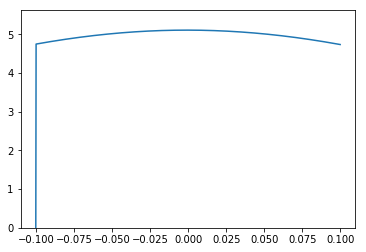

In [24]:
# Plot the marginal pdf in dimension 0 , letting x_d =0
# for all other dimensions d.
xs = np.arange(lower[0], upper[0], (upper[0] - lower[0]) / 1000.)
all_xs = np.zeros((d , len(xs)), float)
all_xs[0, :] = xs
pdf = model.pdf(model.features(all_xs))

import matplotlib.pyplot as plt
plt.plot(xs, pdf)
plt.ylim(0, pdf.max()*1.1)

In [25]:
model.expectations()

array([ -2.37324821e-08,   3.30001025e-03,   9.99999999e-01])

In [26]:
b

array([ 0.    ,  0.0033,  1.    ])

In [27]:
np.allclose(model.expectations(), b, atol=1e-6)

True